In [3]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:

class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, params):

        angle = params['rotation_range'][0]
        angle = (random.uniform(0,1))*random.choice([-1,1])*angle
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = rotate_transform(np.array(image), angle = angle, mode = 'edge')

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5

        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), new_landmarks

    def translation(self, image, landmarks, params):
        image_shape = np.array(image).shape
        ty = random.uniform(params['height_shift_range'][0]*image_shape[0],          
                            params['height_shift_range'][1]*image_shape[0])
        tx = random.uniform(params['width_shift_range'][0]*image_shape[1],
                            params['width_shift_range'][1]*image_shape[1] )

        
        horizontal_shift =  tx*random.choice([-1,1])
        vertical_shift = ty*random.choice([-1,1])
        horizontal_shift_normalised = horizontal_shift/image_shape[1]
        vertical_shift_normalised =  vertical_shift/image_shape[0]

        transform = AffineTransform(translation=(-horizontal_shift,-vertical_shift))

        image = warp(np.array(image),transform,mode='edge')

        landmarks = landmarks + torch.tensor([horizontal_shift_normalised,vertical_shift_normalised])
  
        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), landmarks
        
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def zoom(self, image, landmarks, params):

        landmarks = landmarks.astype(int)
        img_shape = np.array(image).shape
        zoom = random.uniform(params['zoom_range'][0],params['zoom_range'][1])
        image = TF.resize(image,(int(img_shape[0]*zoom), int(img_shape[1]*zoom)) )
        scale_transform = torch.tensor([[zoom, 0], 
                                        [0, zoom]])
        landmarks = np.matmul(landmarks, scale_transform).float()
        new_img_shape = np.array(image).shape
        landmarks = landmarks / torch.tensor([new_img_shape[1], new_img_shape[0]])
        
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks
    


    def __call__(self, image, landmarks, params):

        # set checked image and landmark to landmark_ and image_ (this is for making sure we use the last checked tranformed instead of wrongly tranformed to do the following               # tranform)
        
        # -----------------------
        image_ = Image.fromarray(image.copy())
        landmarks_ = landmarks.copy()
        # -----------------------

        # ZOOM
        image , landmarks = self.zoom(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        # correct this becuase hight and with is different sizes # NOTE fix
        landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1]  
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.zoom(image_, landmarks_, params)
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 

        # ----------------------
        image_ = image
        landmarks_ = landmarks
        # ----------------------

        # RESIZE
        image, landmarks = self.resize(image_, landmarks_, (224, 224))
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.resize(image_, landmarks_, (224, 224))
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 
        landmarks_ = landmarks
        image_ = image

        # ----------------------
        #image_, landmarks_ = self.color_jitter(image_, landmarks_)
        # ----------------------
        
        # ROTATE
        image, landmarks = self.rotate(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.rotate(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------

        # TRANSLATION
        image, landmarks = self.translation(image, landmarks, params)

        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.translation(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------
 
        
        image = TF.to_tensor(image)
        # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks


class LandmarksDataset():

    def __init__(self, transform=None,zoom = [1.0 - 0.03258157476873315, 1.0 + 0.03258157476873315], rotation = [22], height_shift= [0,0.03003200603616672], width_shift= [0,0.03003200603616672 ]):

        df = pd.read_csv('C:/Users/dylan/Work-Projects/msc_haar/tsetsedata_2019_left_commas/annotations_left.txt',index_col=0, header=None)

        df2 =  pd.read_csv('C:/Users/dylan/Work-Projects/msc_haar/flipped_left.csv', index_col= 0)
        self. tranform = transform
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
        self.image_filenames = []
        self.landmarks = []
        self.transform = transform
        self.image_dir = 'C:/Users/dylan/Work-Projects/msc_haar/tsetsedata_2019_left_commas/images_left/'
        self.image_dir2 = 'C:/Users/dylan/Work-Projects/msc_haar/tsetsedata_2019_right_commas/flipped_left/'
        self.TransF_ = True

       # ------------------- Append left wings data to dataset class ------------

        for filename in df.index[:]:
            self.image_filenames.append(os.path.join(self.image_dir, filename))
            

            landmarks = []
            for num in range(1, 23, 2):
                
                x_coordinate = df.loc[filename,num] - 1
                y_coordinate = df.loc[filename, num+1] - 1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        

        assert len(self.image_filenames) == len(self.landmarks)

        # ------------------ Append flipped right wings data to dataset class-----


        for filename in df2.index[:]:

            self.image_filenames.append(os.path.join(self.image_dir2, filename))

            landmarks = []
            for num in range(1, 23, 2):
                x_coordinate = df2.loc[filename,'{}'.format(num)] +1
                y_coordinate = df2.loc[filename, '{}'.format(num+1)] +1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

        # ----------------------

    def TransF(self):
        self.TransF_ = True
    def NoTransF(self):
        self.TransF_ = False
    def set_params(self, zoom = [0.95, 0.105], rotation = [10], height_shift= [0,0.05], width_shift= [0,0.05]):
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        params = {'zoom_range': self.zoom, 'rotation_range':self.rotation, 'height_shift_range': self.height_shift, 'width_shift_range': self.width_shift }
        image_ = plt.imread(self.image_filenames[index])
    
        landmarks_ = self.landmarks[index]
        image = plt.imread(self.image_filenames[index])
    
        landmarks = self.landmarks[index]
        
        if self.transform and self.TransF_:
            
            image, landmarks = self.transform(image_, landmarks_, params)
            image_shape = image.shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*224 > image_shape[1] 
            while landmarks_bool.any() or landmarks_outofbounds.any():
                image, landmarks = self.transform(image_, landmarks_, params)
                landmarks_bool = landmarks < 0
                landmarks_outofbounds = landmarks*224 > image_shape[1] 
        else:
            img_shape = image.copy().shape
            image = Image.fromarray(image)
            image = TF.resize(image, (224,224))
            landmarks = torch.tensor(landmarks) / torch.tensor([img_shape[1],img_shape[0]])
            image = TF.to_tensor(image)
            # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
            image = TF.normalize(image, [0.5], [0.5])



        landmarks = torch.tensor(landmarks) - 0.5
        return image, landmarks


DataSet = LandmarksDataset(Transforms())

In [5]:

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

'''
You instantiate it with the same arguments used for the normalize. and then use it the same way

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(tensor)

'''

'\nYou instantiate it with the same arguments used for the normalize. and then use it the same way\n\nunorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))\nunorm(tensor)\n\n'

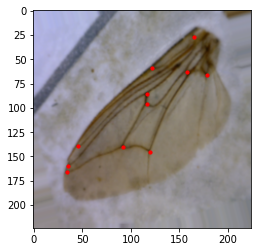

In [6]:
image_, landmarks = DataSet[2]
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image_)

landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
image = image_.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')

In [7]:
class resnet50(nn.Module):
    def __init__(self,num_classes=22):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50(pretrained=True)
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [8]:
DataSet.TransF()
#DataSet.resize(244)
dataset = DataSet
# split the dataset into validation and test sets
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)



The length of Train set is 1452
The length of Valid set is 484
The length of Valid set is 484


In [9]:
# helper functions
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [8]:
import math
network = resnet50()
#network.load_state_dict(torch.load('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/models/model_resnet50_regressor_finetune2.pth'))
network.cuda()

torch.autograd.set_detect_anomaly(True)


loss_list = {'train': [], 'val':[], 'time': []}   

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 300

start_time = time.time()
for epoch in range(1,num_epochs+1):
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):

        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
      
        predictions = network(images)

        optimizer.zero_grad()
      
        
        # find the loss for the current step
    
        loss_train_step = criterion(predictions, landmarks)
  
        
        # calculate the gradients
 
        loss_train_step.backward()
    
        
        # update the parameters
  
        optimizer.step()
    
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
  
            images, landmarks = next(iter(valid_loader))
   
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.8f}  Valid Loss: {:.8f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_list['train'].append(loss_train)
    loss_list['val'].append(loss_valid)
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/regressors/models/model_resnet50_regressor_finetune.pth') 
        print("\nMinimum Validation Loss of {:.8f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     #0.000034
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
loss_list['time'].append(time.time()-start_time)

f = open("C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/regressors/training_losses/model_resnet50_regressor_finetune_trainingdata.pkl","wb")
pickle.dump(loss_list,f)
f.close()

Train Steps: 43/59  Loss: 0.01279262 

KeyboardInterrupt: 

In [16]:
import math
network = resnet50()
network.load_state_dict(torch.load('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/models/model_resnet50_regressor_finetune2.pth'))
network.cuda()

torch.autograd.set_detect_anomaly(True)


loss_list = {'train': [], 'val':[], 'time': []}   

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.00001)

loss_min = np.inf
num_epochs = 150

start_time = time.time()
for epoch in range(1,num_epochs+1):
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):

        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
      
        predictions = network(images)

        optimizer.zero_grad()
      
        
        # find the loss for the current step
    
        loss_train_step = criterion(predictions, landmarks)
  
        
        # calculate the gradients
 
        loss_train_step.backward()
    
        
        # update the parameters
  
        optimizer.step()
    
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
  
            images, landmarks = next(iter(valid_loader))
   
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.8f}  Valid Loss: {:.8f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_list['train'].append(loss_train)
    loss_list['val'].append(loss_valid)
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/models/model_resnet50_regressor_finetune3.pth') 
        print("\nMinimum Validation Loss of {:.8f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     #0.000034
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
loss_list['time'].append(time.time()-start_time)

f = open("model_resnet50_regressor_finetune_trainingdata3.pkl","wb")
pickle.dump(loss_list,f)
f.close()




Valid Steps: 25/25  Loss: 0.00001585 
--------------------------------------------------
Epoch: 1  Train Loss: 0.00000822  Valid Loss: 0.00001585
--------------------------------------------------

Minimum Validation Loss of 0.00001585 at epoch 1/150
Model Saved

Valid Steps: 25/25  Loss: 0.00001752 
--------------------------------------------------
Epoch: 2  Train Loss: 0.00000705  Valid Loss: 0.00001752
--------------------------------------------------
Valid Steps: 25/25  Loss: 0.00001553 
--------------------------------------------------
Epoch: 3  Train Loss: 0.00000673  Valid Loss: 0.00001553
--------------------------------------------------

Minimum Validation Loss of 0.00001553 at epoch 3/150
Model Saved

Valid Steps: 25/25  Loss: 0.00001571 
--------------------------------------------------
Epoch: 4  Train Loss: 0.00000624  Valid Loss: 0.00001571
--------------------------------------------------
Valid Steps: 25/25  Loss: 0.00001656 
----------------------------------------

In [14]:
import pickle
f = open("model_resnet50_regressor_finetune_trainingdata.pkl","wb")
pickle.dump(loss_list,f)
f.close()
